# Introduction

In a [previous post](//ccom.uprrp.edu/~humberto/very-small-rsa-example.html) we did a very small example of RSA, following [the tutorial by Barry Steyn](http://doctrina.org/How-RSA-Works-With-Examples.html). For working with modular integer arithmetic we used functions from a [toy RSA implementation by Alex Roper](https://github.com/calmofthestorm/toys/blob/master/rsa/rsa.py).

That toy implementation has functions for doing plain old RSA with larger keys, and support for encoding strings (and files, from the command line). We're going to use them today to encrypt and sign simple messages.

# Generating keys

With the rsa module, we can generate keys of a specified number of bits. Keys smaller than 2048 bits are not considered secure, but for this example we'll use smaller keys to speed up key generation.

In [1]:
import rsa

foo = rsa.RSAPrivateKey(128)

Even with the reduced key size we specified, the public modulus is a very large number.

In [2]:
foo.N

69550498568599248814636262475927880397153549410739391320974684455051368768161L

# Factoring

Factoring this would require serious resources. Factorizing with the sieve of erathostenes. See stack overflow.


In [3]:
import primefac
import timeit

Let's make some primes and factor them.

In [4]:
keysizes = range(8, 81, 8)

In [5]:
for bits in keysizes:
    k = rsa.RSAPrivateKey(bits)
    print bits, k.N
    %timeit -n 1 -r 1 list(primefac.primefac(k.N))

8 35183
1 loops, best of 1: 175 µs per loop
16 2202514189
1 loops, best of 1: 987 µs per loop
24 182215549431359
1 loops, best of 1: 18.6 ms per loop
32 9473547811385071913
1 loops, best of 1: 595 ms per loop
40 733371207625941664998479
1 loops, best of 1: 1.05 s per loop
48 59511441464217438102568228651
1 loops, best of 1: 5.74 s per loop
56 2613836591888260129297961647816633
1 loops, best of 1: 1.1 s per loop
64 184769131732338408876636008980787900621
1 loops, best of 1: 35.2 s per loop
72 7062950385522509169157930068592940176758811
1 loops, best of 1: 23.3 s per loop
80 945935078743597431682519190640708990971927975837
1 loops, best of 1: 37.9 s per loop


In [6]:
times = [175e-4, 987e-4, 18.6e-3, 595e-3, 1.05, 5.74, 1.1, 35.2, 23.3, 37.9]

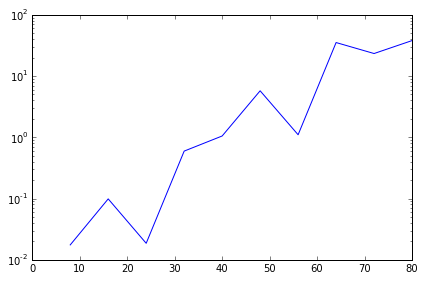

In [7]:
%matplotlib inline
import matplotlib, numpy
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(keysizes, times)
plt.yscale('log')
fig.tight_layout()


In [8]:
foo.N

69550498568599248814636262475927880397153549410739391320974684455051368768161L

As before, the public key is (e, N) and the private key is (d, N).

In [9]:
foo.e

7

In [10]:
foo.d

39743142039199570751220721414815931655213562129409507979705512251076052783143L

I modified rsa.py to store p, q, and phi(n), so I can dig around the internals of RSA.

In [11]:
foo.phi

69550498568599248814636262475927880396623733726466638964484646439383092370500L

We can quickly verify that e and d are multiplicative inverses in the integers modulo phi(n).

In [12]:
(foo.e * foo.d) % foo.phi

1L

# Encryption

If foo wants to send an encrypted message to bar, he will need bar's public key.

In [13]:
bar = rsa.RSAPrivateKey(128)
barpub = bar.GetPublicKey()

We will prepare a message to send to bar.

In [14]:
m = "Attack at dawn. This is a really long message to see if I can get rsa \
to encode it as more than one number."

Recall from last post that we can only encode numbers smaller than n. If we wish to send a longer message, we need to divide it into smaller pieces and send a sequence. For this we need to know bar's public modulus.

In [15]:
encoded = rsa.Message.Encode(m, barpub.N)
encoded.numbers

[115648799396826751567766945599864979770100194381312838842529118569426414700L,
 214012274130603322894259128424238691739369727293888509978752859858830192160L,
 182685454824088443191059084189136997345550917941544886668325422864334353512L,
 172144231835021845661017141195722362689495106685351054972168510011550466048L]

Now we are ready to compute the cyphertext. This transforms the encoded message into a cyphertext that only bar's private key can decrypt.

In [16]:
c = barpub.Encrypt(encoded)

In [17]:
c.numbers

[11166131506805351395600319115738595642433728734479689256313552732877670959227L,
 11528112540522313404245345275623565705592749354729694613502671450504339718378L,
 44507426050276491069955691988155496830453022713213710513888678102680138312985L,
 41820501200035057043301872676477553819863607065308403135697928635154775420156L]

In [18]:
bar.Decrypt(c).Decode()

'Attack at dawn. This is a really long message to see if I can get rsa to encode it as more than one number.'

# Signatures

A digital signature is just a message that has been encrypted with someone's private key. Thus anyone with the public key can verify that the message comes from the owner of the private key, and that no one has altered the message. 

In [19]:
reply = "This is really bar."
encoded_reply = rsa.Message.Encode(reply, bar.N)
encoded_reply.numbers

[149135777980097582635656205376687025111355119538120755623372731861778300928L]

We have to compute the signature manually, as the rsa module won't let us do it directly.

In [20]:
s = rsa.modexp(encoded_reply.numbers[0], bar.d, bar.N)

In [21]:
s

10633483093047333118891406887219194390850355482697068508554850257186593135836L

If foo receives a message claiming to come from bar, he can use bar's public key to confirm.

In [22]:
verify = encoded_reply
verify.numbers = [rsa.modexp(s, barpub.e, barpub.N)]

In [23]:
plaintext = rsa.Message.Decode(verify)
plaintext

'This is really bar.'

In [24]:
plaintext == reply

True